# HYPEROPT

## First set of experiments 

In [3]:
# make sure kaggle 1.5.12 is installed and api key is configured (~/.kaggle/kaggle.json), if not then:
# !pip install --upgrade --force-reinstall --no-deps kaggle

# later:
# !kaggle competitions download -c petfinder-pawpularity-score
# !unzip -q petfinder-pawpularity-score.zip -d input

100%|████████████████████████████████████████| 983M/983M [02:56<00:00, 11.6MB/s]
100%|████████████████████████████████████████| 983M/983M [02:56<00:00, 5.84MB/s]


In [69]:
from sklearn import linear_model, ensemble, svm, neighbors, gaussian_process, cross_decomposition, tree, neural_network, model_selection, metrics
from hyperopt import hp, fmin, tpe, STATUS_OK, space_eval, Trials
from hpsklearn import HyperoptEstimator, svc
from scipy.stats import ttest_ind, ttest_ind_from_stats
from sklearn import svm
import seaborn as sns
import pickle as plk
import math
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np


import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load data:

data_dir = "input" #if using the code above
#data_dir = "~/Downloads/petfinder-pawpularity-score" #comment it out if using the code above
df2 = pd.read_csv(f"{data_dir}/train2.csv")
df2

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,...,lime,dark_green,cyan,teal,blue,violet,purple,dark_red,red,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,...,0.0,0.000090,0.000000,0.000603,0.000000,0.000028,0.0,0.001269,0.000007,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,...,0.0,0.000000,0.000000,0.000033,0.000000,0.001019,0.0,0.010453,0.000000,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,...,0.0,0.059440,0.004287,0.413299,0.082291,0.008185,0.0,0.000190,0.000000,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,...,0.0,0.000000,0.000000,0.000006,0.000000,0.000135,0.0,0.000247,0.000000,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,...,0.0,0.000033,0.000000,0.001532,0.000000,0.000938,0.0,0.000451,0.000003,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9907,ffbfa0383c34dc513c95560d6e1fdb57,0,0,0,1,0,0,0,0,0,...,0.0,0.000316,0.000000,0.000288,0.000000,0.000003,0.0,0.000218,0.000000,15
9908,ffcc8532d76436fc79e50eb2e5238e45,0,1,1,1,0,0,0,0,0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000027,0.0,0.000588,0.000712,70
9909,ffdf2e8673a1da6fb80342fa3b119a20,0,1,1,1,0,0,0,0,1,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.002439,0.001207,20
9910,fff19e2ce11718548fa1c5d039a5192a,0,1,1,1,0,0,0,0,1,...,0.0,0.000075,0.000000,0.000081,0.000000,0.000111,0.0,0.048433,0.121717,20


In [4]:
# normalise column values to 0...1
columns_to_normalise = ["hue", 'saturation', 'brightness', 'contrast', 'contrast2', 'blur', 'warmth',
                        'aspect_ratio', 'dpi', 'white', 'light_grey', 'grey', 'black', 'brown',
                        'orange', 'green', 'lime', 'dark_green', 'cyan', 'teal', 'blue',
                        'violet', 'purple', 'dark_red', 'red']

for col in columns_to_normalise:
    df2[col] = df2[col] / df2[col].max()

In [5]:
# Features and labels:
y = df2['Pawpularity']
X = df2.drop(columns = ['Pawpularity', 'Id'])  

**Feature selection functions:**

In [6]:
def drop_features_by_index(X, drops):
    # remove duplicates
    drops = list(dict.fromkeys(drops))

    # go from right to left
    drops.sort(reverse=True)
    for f in drops:
        X = X.drop(X.columns[f], axis=1)

    return X


def get_feature_indices(args):
    indices = [v for k,v in args.items() if k.startswith("drop_feature_")]
    #remove duplicates
    return list(dict.fromkeys(indices))

**Objective function:**

In [7]:
def objective(args):

    global df2

    X = df2.drop(["Pawpularity","Id"], axis=1)
    y = df2["Pawpularity"]

    # calc features to drop
    drops = get_feature_indices(args)
    X = drop_features_by_index(X, drops)

    model_def = args["model"]

    if args["model"]["type"] == "BayesianRidge":
        model = linear_model.BayesianRidge(
            n_iter = model_def["n_iter"],
            alpha_1 = model_def["alpha_1"],
            alpha_2 = model_def["alpha_2"],
            lambda_1 = model_def["lambda_1"],
            lambda_2 = model_def["lambda_1"],
        )

    if args["model"]["type"] == "ElasticNet":
        model = linear_model.ElasticNet(
            alpha=model_def["alpha"],
            l1_ratio=model_def["l1_ratio"]
        )

    if args["model"]["type"] == "SGDRegressor":
        model = linear_model.SGDRegressor(
            alpha=model_def["alpha"],
            l1_ratio=model_def["l1_ratio"]
        )

    if args["model"]["type"] == "MLPRegressor":
        model = neural_network.MLPRegressor(
            hidden_layer_sizes=(model_def["hidden_layer_sizes"],),
            alpha=model_def["alpha"],
            solver=model_def["solver"]
        )

    scores = model_selection.cross_val_score(model, X, y, scoring="neg_root_mean_squared_error") * -1
    return np.mean(scores)

### **Three experiments with different feature spaces, using feature selection:**

**First experiment:**

In [232]:
space = {
    "model": hp.choice("model", [
        {
            "type": "BayesianRidge",
            "n_iter": hp.uniformint("bayes_n_iter", 200, 500),
            "alpha_1": hp.uniform("bayes_alpha_1", 1e-8, 1e-4),
            "alpha_2": hp.uniform("bayes_alpha_2", 1e-8, 1e-4),
            "lambda_1": hp.uniform("bayes_lambda_1", 1e-8, 1e-4),
            "lambda_2": hp.uniform("bayes_lambda_2", 1e-8, 1e-4),
        },
        {
            "type": "ElasticNet",
            "alpha": hp.uniform("elastic_alpha", 0.5, 2),
            "l1_ratio": hp.uniform("elastic_l1", 0, 1)
        },
        {
            "type": "SGDRegressor",
            "alpha": hp.uniform("sgd_alpha", 0.00001, 0.001),
            "l1_ratio": hp.uniform("sgd_l1", 0, 1)
        },
        # {
        #     "type": "MLPRegressor",
        #     "hidden_layer_sizes": hp.choice("mlp_layers_size", [100, 200, 300]),
        #     'alpha':hp.lognormal('mlp_alpha', mu=np.log(1e-4), sigma=1),
        #     'solver':hp.choice('mlp_solver', ['lbfgs', 'sgd', 'adam'])
        # }
    ]),
    "drop_feature_0": hp.uniformint("drop_feature_0", 0, X.shape[1]-1),
    "drop_feature_1": hp.uniformint("drop_feature_1", 0, X.shape[1]-1),
    "drop_feature_2": hp.uniformint("drop_feature_2", 0, X.shape[1]-1),
}

best = fmin(objective, space, algo = tpe.suggest, max_evals=10000)
#hyperopt.pyll.stochastic.sample(space)

(space_eval(space, best))


100%|██████████| 10000/10000 [1:58:26<00:00,  1.41trial/s, best loss: 20.54404889010004]


{'drop_feature_0': 3,
 'drop_feature_1': 7,
 'drop_feature_2': 19,
 'model': {'alpha_1': 5.0042757161530806e-05,
  'alpha_2': 2.2305134933294197e-05,
  'lambda_1': 5.8501650382826934e-05,
  'lambda_2': 5.954285663965207e-05,
  'n_iter': 319,
  'type': 'BayesianRidge'}}

**Second experiment:**

In [233]:
space2 = {
    "model": hp.choice("model", [
        {
            "type": "BayesianRidge",
            "n_iter": hp.uniformint("bayes_n_iter", 200, 500),
            "alpha_1": hp.uniform("bayes_alpha_1", 1e-8, 1e-4),
            "alpha_2": hp.uniform("bayes_alpha_2", 1e-8, 1e-4),
            "lambda_1": hp.uniform("bayes_lambda_1", 1e-8, 1e-4),
            "lambda_2": hp.uniform("bayes_lambda_2", 1e-8, 1e-4),
        },
        {
            "type": "ElasticNet",
            "alpha": hp.uniform("elastic_alpha", 0.5, 2),
            "l1_ratio": hp.uniform("elastic_l1", 0, 1)
        },
        {
            "type": "SGDRegressor",
            "alpha": hp.uniform("sgd_alpha", 0.00001, 0.001),
            "l1_ratio": hp.uniform("sgd_l1", 0, 1)
        },
        {
            "type": "MLPRegressor",
            "hidden_layer_sizes": hp.choice("mlp_layers_size", [100, 200, 300]),
            'alpha':hp.lognormal('mlp_alpha', mu=np.log(1e-4), sigma=1),
            'solver':hp.choice('mlp_solver', ['lbfgs', 'sgd', 'adam'])
        }
    ]),
    "drop_feature_0": hp.uniformint("drop_feature_0", 0, X.shape[1]-1),
    "drop_feature_1": hp.uniformint("drop_feature_1", 0, X.shape[1]-1),
    "drop_feature_2": hp.uniformint("drop_feature_2", 0, X.shape[1]-1),
}

best2 = fmin(objective, space2, algo = tpe.suggest, max_evals=10000)
#hyperopt.pyll.stochastic.sample(space)

(space_eval(space2, best2))

100%|██████████| 10000/10000 [5:07:27<00:00,  1.84s/trial, best loss: 20.544048831904863]  


{'drop_feature_0': 3,
 'drop_feature_1': 19,
 'drop_feature_2': 7,
 'model': {'alpha_1': 9.975485827537099e-05,
  'alpha_2': 4.280861256930258e-05,
  'lambda_1': 1.0962300332032549e-07,
  'lambda_2': 1.0676469280073962e-05,
  'n_iter': 282,
  'type': 'BayesianRidge'}}

**Third experiment:**

In [260]:
space3 = {
    "model": hp.choice("model", [
        {
            "type": "BayesianRidge",
            "n_iter": hp.uniformint("bayes_n_iter", 100, 900),
            "alpha_1": hp.uniform("bayes_alpha_1", 1e-10, 1e-1),
            "alpha_2": hp.uniform("bayes_alpha_2", 1e-10, 1e-1),
            "lambda_1": hp.uniform("bayes_lambda_1", 1e-10, 1e-1),
            "lambda_2": hp.uniform("bayes_lambda_2", 1e-10, 1e-1),
        },
        {
            "type": "ElasticNet",
            "alpha": hp.uniform("elastic_alpha", 0.1, 4),
            "l1_ratio": hp.uniform("elastic_l1", 0, 1)
        },
        {
            "type": "SGDRegressor",
            "alpha": hp.uniform("sgd_alpha", 0.000001, 0.1),
            "l1_ratio": hp.uniform("sgd_l1", 0, 1)
        },
        {
            "type": "MLPRegressor",
            "hidden_layer_sizes": hp.choice("mlp_layers_size", [100, 200, 300, 500]),
            'alpha':hp.uniform('mlp_alpha', 0.000001, 0.1),
            'solver':hp.choice('mlp_solver', ['lbfgs', 'sgd', 'adam'])
        }
    ]),
    "drop_feature_0": hp.uniformint("drop_feature_0", 0, X.shape[1]-1),
    "drop_feature_1": hp.uniformint("drop_feature_1", 0, X.shape[1]-1),
    "drop_feature_2": hp.uniformint("drop_feature_2", 0, X.shape[1]-1),
    "drop_feature_3": hp.uniformint("drop_feature_3", 0, X.shape[1]-1),
    "drop_feature_4": hp.uniformint("drop_feature_4", 0, X.shape[1]-1),
    "drop_feature_5": hp.uniformint("drop_feature_5", 0, X.shape[1]-1),
}

best3 = fmin(objective, space3, algo = tpe.suggest, max_evals=1000)


(space_eval(space3, best3))

100%|██████████| 1000/1000 [03:14<00:00,  5.15trial/s, best loss: 20.543172298345088]


{'drop_feature_0': 34,
 'drop_feature_1': 12,
 'drop_feature_2': 19,
 'drop_feature_3': 9,
 'drop_feature_4': 7,
 'drop_feature_5': 9,
 'model': {'alpha_1': 0.07113899442241944,
  'alpha_2': 0.027808833733416437,
  'lambda_1': 4.3632812506737284e-05,
  'lambda_2': 0.08582921220593691,
  'n_iter': 774,
  'type': 'BayesianRidge'}}

We see that best model was achieved in trial 6, after 03:14 minutes, and its **RMSE was 20.54317**.

## Statistical test:

In [266]:
#X = df2.drop(["Pawpularity","Id"], axis=1)
#X = drop_features_by_index(X, [3,9,7,19,10,5])
#y = df2["Pawpularity"]
#
#scores_baseline = model_selection.cross_val_score(linear_model.BayesianRidge(), X, y, scoring="neg_root_mean_squared_error") * -1
#scores_best_model = model_selection.cross_val_score(linear_model.BayesianRidge(
#    alpha_1=0.06748333082329638,
#    alpha_2=0.07190365480503146,
#    lambda_1=4.960510739533382e-05,
#    lambda_2=0.05681786469111417,
#    n_iter=827,
#), X, y, scoring="neg_root_mean_squared_error") * -1
#
#
#t,p = ttest_ind(
#    a = scores_baseline,
#    b = scores_best_model
#)
#
#np.round(p, 4)

0.9998

In [30]:
X = df2.drop(["Pawpularity","Id"], axis=1)
X = drop_features_by_index(X, [34, 12, 19, 9, 7])
y = df2["Pawpularity"]

scores_baseline = model_selection.cross_val_score(linear_model.BayesianRidge(), X, y, scoring="neg_root_mean_squared_error") * -1

scores_best_model = model_selection.cross_val_score(linear_model.BayesianRidge(
    alpha_1=0.07114,
    alpha_2=0.02781,
    lambda_1=4.36328e-05,
    lambda_2=0.085829,
    n_iter=774,
), X, y, scoring="neg_root_mean_squared_error") * -1


t,p = ttest_ind(
    a = scores_baseline,
    b = scores_best_model
)

print('Results in cross-validation:')
print('\n1) Baseline model:')
print('RMSEs:', scores_baseline)
print('Avg. RMSE:', np.mean(scores_baseline))
print('\n2) Best model built after hyperparameter tuning:')
print('RMSEs:', scores_best_model)
print('Avg. RMSE:', np.mean(scores_best_model))

Results in cross-validation:

1) Baseline model:
RMSEs: [20.69268855 20.77399254 20.83894278 20.0912567  20.34548248]
Avg. RMSE: 20.548472607914363

2) Best model built after hyperparameter tuning:
RMSEs: [20.69270067 20.77398017 20.83837041 20.09123732 20.34541697]
Avg. RMSE: 20.548341106591756


In [31]:
print('STATISTICAL TEST:')
print('test statistic:', np.round(t, 5))
print('p-value:', np.round(p, 5))

STATISTICAL TEST:
test statistic: 0.00065
p-value: 0.9995


The very large p-value shows that difference between results (cross-validation RMSEs) of the baseline model and of the best model built after hypermarameter tuning with HyperOpt was not statistically significant. 

## Second set of experiments 

In this experiment, we try to define the feature space better, and also add more models. Here, will also use the trials object to later extract the exact time when baseline was surpassed. Conttrary to previous experiments, we no longer use feature selection, beacuse we now have many more models and feature selection takes takes extra time. Also, actually four of the added models already implement feature selection on their own (they have respective hyperparameter 'max_features'). 

We choose number of iterations to be 1300, which corresponds to 100 iterations per model on average (since we are now considering 13 models).

In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge #
from sklearn.linear_model import Lasso #
from sklearn.cross_decomposition import PLSRegression #
from sklearn.ensemble import GradientBoostingRegressor #
from sklearn.ensemble import BaggingRegressor #
from sklearn.ensemble import AdaBoostRegressor #
from sklearn.tree import DecisionTreeRegressor #
from sklearn.linear_model import ElasticNet #
from sklearn.linear_model import SGDRegressor #
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neighbors import RadiusNeighborsRegressor

In [32]:
# Features and labels:
y = df2['Pawpularity']
X = df2.drop(columns = ['Pawpularity', 'Id'])  

**Objective function:**

In [61]:
def objective(args):

    global df2

    X = df2.drop(["Pawpularity","Id"], axis=1)
    y = df2["Pawpularity"]

    model_def = args["model"]

    if args["model"]["type"] == "ElasticNet":
        model = ElasticNet(
            alpha=model_def["alpha"],
            l1_ratio=model_def["l1_ratio"],
            tol=model_def["tol"]
        )

    if args["model"]["type"] == "SGDRegressor":
        model = SGDRegressor(
            alpha=model_def["alpha"],
            l1_ratio=model_def["l1_ratio"],
            penalty=model_def["penalty"]
        )  
        
    if args["model"]["type"] == "AdaBoostRegressor":
        model = AdaBoostRegressor(
            n_estimators=model_def["n_estimators"],
            learning_rate=model_def["learning_rate"]
        )
        
    if args["model"]["type"] == "DecisionTreeRegressor":
        model = DecisionTreeRegressor(
            max_depth=model_def["max_depth"],
            min_samples_split=model_def["min_samples_split"],
            max_features=model_def["max_features"],
            ccp_alpha=model_def["ccp_alpha"]
        )

    if args["model"]["type"] == "BaggingRegressor":
        model = BaggingRegressor(
            n_estimators=model_def["n_estimators"],
            max_samples=model_def["max_samples"],
            max_features=model_def["max_features"]
        )
        
    if args["model"]["type"] == "GradientBoostingRegressor":
        model = GradientBoostingRegressor(
            learning_rate=model_def["learning_rate"],
            n_estimators=model_def["n_estimators"],
            subsample=model_def["subsample"],
            min_samples_split=model_def["min_samples_split"],
            max_depth=model_def["max_depth"],
            max_features=model_def["max_features"],
            alpha=model_def["alpha"]
        )        
        
    if args["model"]["type"] == "PLSRegression":
        model = PLSRegression(
            n_components=model_def["n_components"],
            scale=model_def["scale"],
            tol=model_def["tol"]
        )

    if args["model"]["type"] == "Lasso":
        model = Lasso(
            alpha=model_def["alpha"],
            tol=model_def["tol"],
            positive=model_def["positive"]
        )        

    if args["model"]["type"] == "Ridge":
        model = Ridge(
            alpha=model_def["alpha"],
            solver=model_def["solver"]
        )

    if args["model"]["type"] == "RadiusNeighborsRegressor":
        model = RadiusNeighborsRegressor(
            radius=model_def["radius"],
            weights=model_def["weights"]
        )

    if args["model"]["type"] == "KNeighborsRegressor":
        model = KNeighborsRegressor(
            n_neighbors=model_def["n_neighbors"]
        )

    if args["model"]["type"] == "SVR":
        model = SVR(
            C=model_def["C"],
            kernel=model_def["kernel"],
            gamma=model_def["gamma"],
            coef0=model_def["coef0"]
        )        

    if args["model"]["type"] == "RandomForestRegressor":
        model = RandomForestRegressor(
            max_depth=model_def["max_depth"],
            min_samples_leaf=model_def["min_samples_leaf"],
            n_estimators=model_def["n_estimators"],
            max_features=model_def["max_features"],
            bootstrap=model_def["bootstrap"],
            ccp_alpha=model_def["ccp_alpha"]
        )
        
    scores = model_selection.cross_val_score(model, X, y, scoring="neg_root_mean_squared_error") * -1
    return np.mean(scores)

**Feature space:**

In [62]:
space4 = {
    'model': hp.choice('model', [
        {
            'type': 'ElasticNet',
            'alpha': hp.uniform('elastic_alpha', 0.002, 0.01),
            'l1_ratio':  hp.uniform('elastic_l1_ratio', 0.0001, 1.0),
            'tol': hp.uniform('elastic_tol', 0.01, 0.1)
        },
        {
            'type': 'SGDRegressor',
            'penalty': hp.choice('sgd_enalty', ['l1', 'l2', 'elasticnet']),
            'alpha': hp.uniform('sgd_alpha', 0.005, 0.04),
            'l1_ratio': hp.uniform('sgd_l1_ratio', 0.001, 0.6)
        },
        {
            'type': 'AdaBoostRegressor',
            'n_estimators': hp.choice('ada_n_estimators', [100, 150, 200]),
            'learning_rate': hp.uniform('ada_learning_rate', 0.7, 1.5)
        },
        {
            'type': 'DecisionTreeRegressor',
            'max_depth': hp.uniformint('dt_max_depth', 2, 7),
            'min_samples_split': hp.uniformint('dt_min_samples_split', 3, 20),
            'max_features': hp.uniformint('dt_max_features', 5, 24),
            'ccp_alpha': hp.uniform('dt_ccp_alpha', 0.0, 0.2)
        },        
        {
            'type': 'BaggingRegressor',
            'n_estimators': hp.uniformint('bag_n_estimators', 45, 75),
            'max_samples': hp.uniform('bag_max_samples', 0.1, 0.4),
            'max_features': hp.uniformint('bag_max_features', 5, 24)
        },
        {
            'type': 'GradientBoostingRegressor',
            'learning_rate': hp.uniform('grad_learning_rate', 0.005, 0.07), 
            'n_estimators': hp.uniformint('grad_n_estimators', 60, 150),
            'subsample': hp.uniform('grad_subsample', 0.5, 1.0),
            'min_samples_split': hp.uniformint('grad_min_samples_split', 5, 50),
            'max_depth': hp.uniformint('grad_max_depth', 2, 7),
            'max_features': hp.pchoice('grad_max_features', 
                                      [(0.15, 'auto'), 
                                        (0.85, hp.uniformint('grad_max_features_int', 5, 20))]),
            'alpha': hp.uniform('grad_alpha', 0.3, 0.7)
        }, 
        {
            'type': 'PLSRegression',
            'n_components': hp.uniformint('pls_n_components', 1, 25),
            'scale': hp.choice('pls_positive', [True, False]),
            'tol': hp.uniform('pls_alpha', 1e-06, 1e-02)
        },
        {
            'type': 'Lasso',
            'alpha': hp.uniform('lasso_alpha', 0.005, 0.05),
            'tol': hp.uniform('lasso_tol', 0.05, 0.7),
            'positive':hp.choice('lasso_positive', [True, False]) 
        },        
        {
            'type': 'Ridge',
            'alpha': hp.uniform('ridge_alpha', 0.8, 35.0),
            'solver': hp.choice('ridge_solver', ['auto', 'svd', 'lsqr', 'sag', 'cholesky'])
        },
        {
            'type': 'RadiusNeighborsRegressor',
            'radius': hp.uniform('radius_radius', 0.4, 1.2), # default 1.0
            'weights': hp.choice('radius_weights', ['uniform', 'distance']) #
        },   
        {
            'type': 'KNeighborsRegressor',
            'n_neighbors': hp.choice('knn_n_neighbors', [5, 7, 10, 20, 50, 70, 100, 150, 300, 500, 700, 1000, 1250, 1500]), #
        },
        {
            'type': 'SVR',
            'C': hp.choice('svr_C:', [0.1, 0.5, 1, 5, 10, 20, 50]),
            'kernel': hp.choice('svr_kernel', ['poly', 'rbf', 'linear']), 
            'gamma': hp.uniform('svr_gamma', 0.04, 0.1),
            'coef0': hp.choice('svr_coef0', [0.0, 0.5, 1.0])  
        },        
        {
            'type': 'RandomForestRegressor',
            'max_depth': hp.choice('rf_max_depth', range(2, 7)),
            'min_samples_leaf': hp.uniformint('rf_min_samples_leaf', 3, 10),
            'n_estimators': hp.choice('rf_n_estimators', [30, 50, 75, 100, 200]),
            'max_features': hp.choice('rf_max_features', ['auto', 'log2', 'sqrt']),
            'bootstrap': hp.choice('rf_bootstrap', [True, False]),
            'ccp_alpha': hp.uniform('rf_ccp_alpha', 0.0, 0.05)
        }     
    ])
}

In [63]:
trials = Trials()
best4 = fmin(objective, space4, algo = tpe.suggest, max_evals=1300, trials=trials)

(space_eval(space4, best4))

100%|██████████████████████████████████████████| 1300/1300 [3:02:32<00:00,  8.43s/trial, best loss: 20.524968551544585]


{'model': {'bootstrap': True,
  'ccp_alpha': 0.0340040644312367,
  'max_depth': 5,
  'max_features': 'auto',
  'min_samples_leaf': 5,
  'n_estimators': 75,
  'type': 'RandomForestRegressor'}}

In [66]:
# Save trials object for further analysis:
with open('trials_tabular.plk','wb') as fout:  
    plk.dump([trials], fout)

In [ ]:
## Load trials object:
#with open('trials_tabular.plk','rb') as fin:
#    loaded = plk.load(fin)
#    trials=loaded[0]
#    del loaded

## Least time budget that outperformed the baseline

In [130]:
baseline_rmse = np.mean(scores_baseline)
print('Baseline RMSE:', baseline_rmse)

trials_ = trials.trials 
trials_losses = trials.losses()
iters = [x for x in range(len(trials_losses))]
df_losses = pd.DataFrame(data = [trials_losses, iters]).T
df_losses.columns=['RMSE', 'Iterations']
# df_losses.index = iters
df_losses['Iterations'] = df_losses['Iterations'].astype('int64')

# Iteration where hyperopt first exceeded baseline:
for least_budget, loss in enumerate(trials_losses): 
    if loss< baseline_rmse:
        break

# Best iteration:
best_iter = np.argmin(trials_losses)
best_rmse = np.min(trials_losses)
        
print('\nModel built with hyperopt first exceeded baseline in iteration:', least_budget)
print('Best (smallest) RMSE was', best_rmse,  ', which was achieved in iteration:', best_iter)

Baseline RMSE: 20.548472607914363

Model built with hyperopt first exceeded baseline in iteration: 22
Best (smallest) RMSE was 20.524968551544585 , which was achieved in iteration: 591


**Evolutin of RMSE in iterations:**

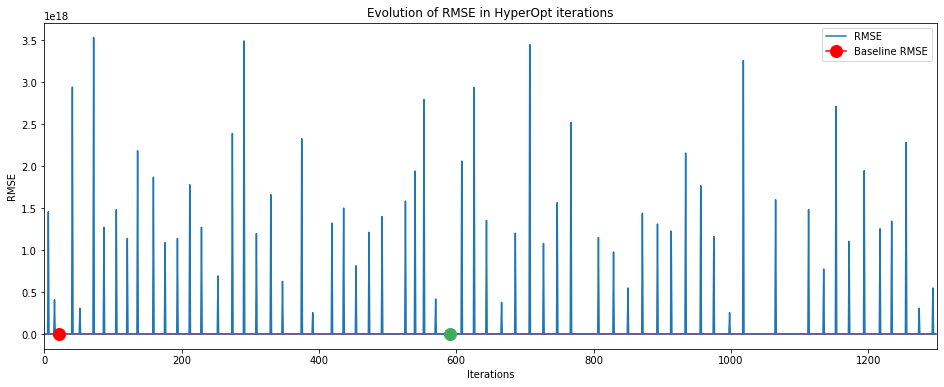

In [144]:
plt.rcParams['figure.figsize'] = (16.0, 6.0)
sns.lineplot(x = 'Iterations', y = 'RMSE', data=df_losses) 
plt.hlines(y = baseline_rmse, xmin = 0, xmax=len(trials_losses)-1, colors=['red'], label='Baseline RMSE')
# plt.annotate()
plt.plot([least_budget], [baseline_rmse], marker='o', markersize=12, color="red") 
plt.plot([best_iter], [best_rmse], marker='o', markersize=12, color="#41ab5d")
plt.legend(labels=['RMSE', 'Baseline RMSE'], facecolor='white', loc='upper right')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title("Evolution of RMSE in HyperOpt iterations")
#plt.ylim(20.52, 20.7)
plt.xlim(0, 1300)
plt.show()

**Same plot, after trimming higher (worse) RMSE values to better see comparison to baseline:**

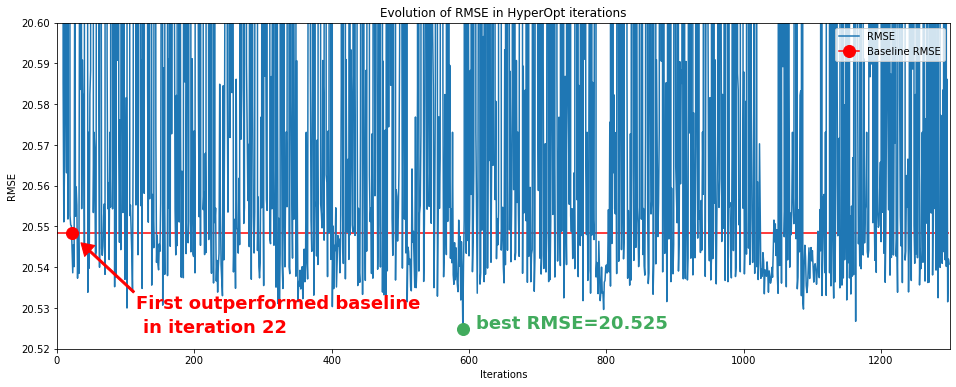

In [145]:
plt.rcParams['figure.figsize'] = (16.0, 6.0)

sns.lineplot(x = 'Iterations', y = 'RMSE', data=df_losses) 
plt.hlines(y = baseline_rmse, xmin = 0, xmax=len(trials_losses)-1, colors=['red'], label='Baseline RMSE')
# plt.annotate()
plt.plot([least_budget], [baseline_rmse], marker='o', markersize=12, color="red")
plt.plot([best_iter], [best_rmse], marker='o', markersize=12, color="#41ab5d")
plt.legend(labels=['RMSE', 'Baseline RMSE'], facecolor='white', loc='upper right')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title("Evolution of RMSE in HyperOpt iterations")
plt.annotate(text = 'First outperformed baseline', xy=(35, 20.546), xytext=(115, 20.53), 
             color = 'red', fontsize=18, weight='bold', arrowprops={'width': 2, 'color': 'red', 'headwidth': 15})
plt.annotate(text = 'in iteration 22', xy=(125, 20.524), 
             color = 'red', fontsize=18, weight='bold')
plt.annotate(text = 'best RMSE=20.525', xy=(610, 20.525), 
             color = '#41ab5d', fontsize=18, weight='bold')
plt.ylim(20.52, 20.6)
plt.xlim(0, 1300)
plt.show()


## Statistical test:

In [148]:
scores_baseline = model_selection.cross_val_score(linear_model.BayesianRidge(), X, y, scoring="neg_root_mean_squared_error") * -1

scores_best_model = model_selection.cross_val_score(RandomForestRegressor(
    bootstrap= True,
    ccp_alpha= 0.0340040644312367,
    max_depth= 5,
    max_features= 'auto',
    min_samples_leaf= 5,
    n_estimators= 75,
), X, y, scoring="neg_root_mean_squared_error") * -1


t,p = ttest_ind(
    a = scores_baseline,
    b = scores_best_model
)

print('Results in cross-validation:')
print('\n1) Baseline model:')
print('RMSEs:', scores_baseline)
print('Avg. RMSE:', np.mean(scores_baseline))
print('\n2) Best model built after hyperparameter tuning:')
print('RMSEs:', scores_best_model)
print('Avg. RMSE:', np.mean(scores_best_model))

Results in cross-validation:

1) Baseline model:
RMSEs: [20.69948656 20.78412876 20.87568089 20.09458321 20.3757668 ]
Avg. RMSE: 20.565929244930903

2) Best model built after hyperparameter tuning:
RMSEs: [20.65525271 20.73145738 20.8752186  20.06733897 20.3611398 ]
Avg. RMSE: 20.538081492408907


In [149]:
print('STATISTICAL TEST:')
print('test statistic:', np.round(t, 5))
print('p-value:', np.round(p, 5))

STATISTICAL TEST:
test statistic: 0.13609
p-value: 0.89511


Although RMSE slightly improved in the second experiment, the p-value still remained very large. Therefore, we must conclude that difference between results (cross-validation RMSEs) of the baseline model and of the best model built after hypermarameter tuning with HyperOpt was not statistically significant. 